# 3. Imagined movement

In this tutorial we will look at imagined movement. Our movement is controlled in the motor cortex where there is an increased level of mu activity (8–12 Hz) when we perform movements. This is accompanied by a reduction of this mu activity in specific regions that deal with the limb that is currently moving. This decrease is called Event Related Desynchronization (ERD). By measuring the amount of mu activity at different locations on the motor cortex, we can determine which limb the subject is moving. Through mirror neurons, this effect also occurs when the subject is not actually moving his limbs, but merely imagining it.

## Credits
The CSP code was originally written by Boris Reuderink of the Donders
Institute for Brain, Cognition and Behavior. It is part of his Python EEG
toolbox: https://github.com/breuderink/eegtools

Inspiration for this tutorial also came from the excellent code example
given in the book chapter:
 
Arnaud Delorme, Christian Kothe, Andrey Vankov, Nima Bigdely-Shamlo,
Robert Oostenveld, Thorsten Zander, and Scott Makeig. MATLAB-Based Tools
for BCI Research, In _(B+H)CI: The Human in Brain-Computer Interfaces and
the Brain in Human-Computer Interaction._ Desney S. Tan and Anton Nijholt
(eds.), 2009, 241-259, http://dx.doi.org/10.1007/978-1-84996-272-8

## About the data
The dataset for this tutorial is provided by the fourth BCI competition.
Before you continue with this tutorial, please, go to http://www.bbci.de/competition/iv/#download
and fill in your name and email address.
You don't need to actually download the data, since it is installed in the virtual server already, but this way, the wonderful organizers of the competition get notified that their data is still being used and by whom.

[Description of the data](http://bbci.de/competition/iv/desc_1.html)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Executing the code cell below will load the data:

In [2]:
import numpy as np
import scipy.io

m = scipy.io.loadmat('data/BCICIV_calib_ds1d.mat', struct_as_record=True)

# SciPy.io.loadmat does not deal well with Matlab structures, resulting in lots of
# extra dimensions in the arrays. This makes the code a bit more cluttered

sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

In [3]:
len(event_onsets[0])
len(event_codes[0])

200

Now we have the data in the following python variables:

In [4]:
# Print some information
print('Shape of EEG:', EEG.shape)
print('Sample rate:', sample_rate)
print('Number of channels:', nchannels)
print('Channel names:', channel_names)
print('Number of events:', len(event_onsets))
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)

Shape of EEG: (59, 190473)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


This is a large recording: 59 electrodes where used, spread across the entire scalp. The subject was given a cue and then imagined either right hand movement or the movement of his feet. As can be seen from the [Homunculus](http://en.wikipedia.org/wiki/Cortical_homunculus), foot movement is controlled at the center of the motor cortex (which makes it hard to distinguish left from right foot), while hand movement is controlled more lateral.



## Plotting the data

The code below cuts trials for the two classes and should look familiar if you've completed the previous tutorials. Trials are cut in the interval [0.5–2.5 s] after the onset of the cue.

In [5]:
# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 2.5 seconds
win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

# Length of the time window
nsamples = len(win)

# Loop over the classes (right, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):
    
    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]
    
    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    
    # Extract each trial
    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]
  
# Some information about the dimensionality of the data (channels x time x trials)
print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 200, 100)
Shape of trials[cl2]: (59, 200, 100)


In [6]:
trials[cl1].shape[2]

100



Since the feature we're looking for (a decrease in $\mu$-activity) is a frequency feature, lets plot the PSD of the trials in a similar manner as with the SSVEP data. The code below defines a function that computes the PSD for each trial (we're going to need it again later on):

In [7]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal
    
    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.  
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''
    
    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, 101, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs

In [8]:
# Apply the function
psd_r, freqs = psd(trials[cl1])
psd_f, freqs = psd(trials[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

In [9]:
psd_r.shape

(59, 101, 100)

The function below plots the PSDs that are calculated with the above function. Since plotting it for 118 channels will clutter the display, it takes the indices of the desired channels as input, as well as some metadata to decorate the plot.

In [10]:
import matplotlib.pyplot as plt

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().
    
    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd() 
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

Lets put the `plot_psd()` function to use and plot three channels:

 1. C3: Central, left
 2. Cz: Central, central
 3. C4: Central, right

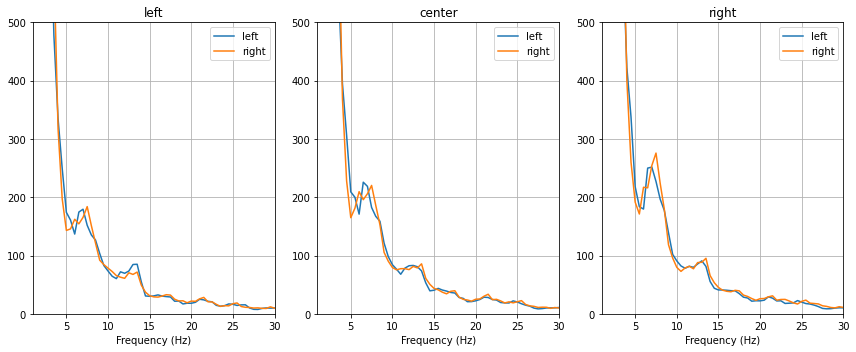

In [11]:
plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=500
)

A spike of mu activity can be seen on each channel for both classes. At the right hemisphere, the mu for the left hand movement is lower than for the right hand movement due to the ERD. At the left electrode, the mu for the right hand movement is reduced and at the central electrode the mu activity is about equal for both classes. This is in line with the theory that the left hand is controlled by the right hemisphere and the feet are controlled centrally.

## Classifying the data

We will use a machine learning algorithm to construct a model that can distinguish between the right hand and foot movement of this subject. In order to do this we need to:

 1. find a way to quantify the amount of mu activity present in a trial
 2. make a model that describes expected values of mu activity for each class
 3. finally test this model on some unseen data to see if it can predict the correct class label

We will follow a classic BCI design by Blankertz et al. [1] where they use the logarithm of the variance of the signal in a certain frequency band as a feature for the classifier.

[1] Blankertz, B., Dornhege, G., Krauledat, M., Müller, K.-R., & Curio, G. (2007). The non-invasive Berlin Brain-Computer Interface: fast acquisition of effective performance in untrained subjects. *NeuroImage*, 37(2), 539–550. doi:10.1016/j.neuroimage.2007.01.051

The script below designs a band pass filter using [`scipy.signal.irrfilter`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) that will strip away frequencies outside the 8--15Hz window. The filter is applied to all trials:

In [12]:
import scipy.signal 

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)
    
    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the niquist frequency, which is the sample rate divided by 2:
    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)
    
    return trials_filt

In [13]:
# Apply the function
trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

Plotting the PSD of the resulting `trials_filt` shows the suppression of frequencies outside the passband of the filter:

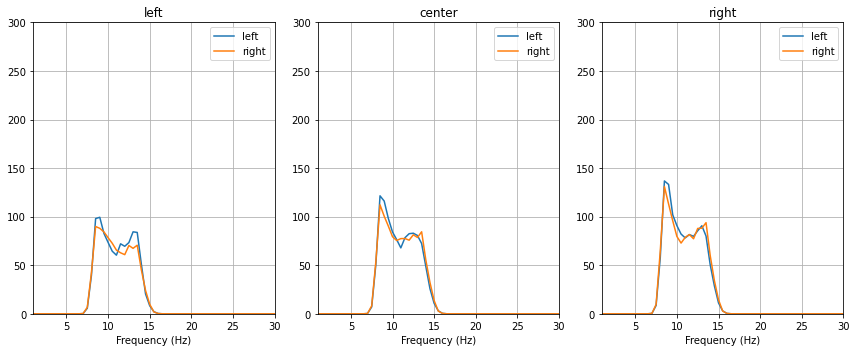

In [14]:
psd_r, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=300
)

As a feature for the classifier, we will use the logarithm of the variance of each channel. The function below calculates this:

In [15]:
# Calculate the log(var) of the trials
def logvar(trials):
    '''
    Calculate the log-var of each channel.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.
        
    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))

In [16]:
# Apply the function
trials_logvar = {cl1: logvar(trials_filt[cl1]),
                 cl2: logvar(trials_filt[cl2])}

In [17]:
logvar(trials_filt[cl1]).shape

(59, 100)

Below is a function to visualize the logvar of each channel as a bar chart:

In [18]:
def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
    '''
    plt.figure(figsize=(12,5))
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

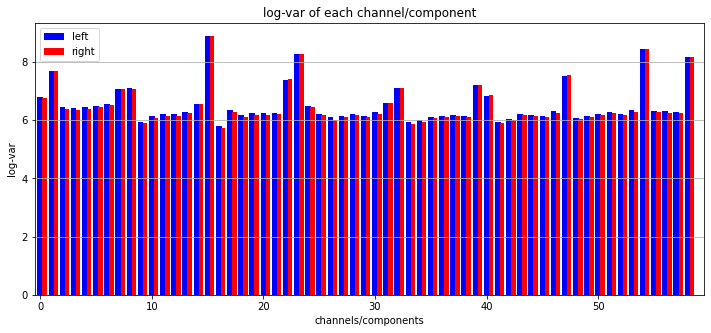

In [19]:
# Plot the log-vars
plot_logvar(trials_logvar)

We see that most channels show a small difference in the log-var of the signal between the two classes. The next step is to go from 118 channels to only a few channel mixtures. The CSP algorithm calculates mixtures of channels that are designed to maximize the difference in variation between two classes. These mixures are called spatial filters.

In [20]:
from numpy import linalg

def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing foot movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [21]:
# Apply the functions
W = csp(trials_filt[cl1], trials_filt[cl2])
trials_csp = {cl1: apply_mix(W, trials_filt[cl1]),
              cl2: apply_mix(W, trials_filt[cl2])}

In [22]:
W.shape

(59, 59)

To see the result of the CSP algorithm, we plot the log-var like we did before:

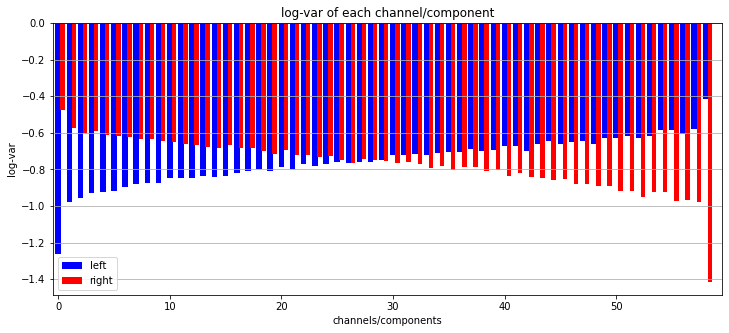

In [23]:
trials_logvar = {cl1: logvar(trials_csp[cl1]),
                 cl2: logvar(trials_csp[cl2])}
plot_logvar(trials_logvar)

Instead of 118 channels, we now have 118 mixtures of channels, called components. They are the result of 118 spatial filters applied to the data.

The first filters maximize the variation of the first class, while minimizing the variation of the second. The last filters maximize the variation of the second class, while minimizing the variation of the first.

This is also visible in a PSD plot. The code below plots the PSD for the first and last components as well as one in the middle:

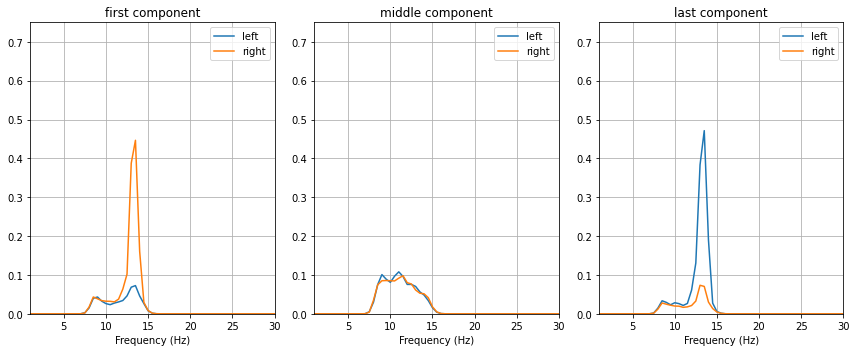

In [24]:
psd_r, freqs = psd(trials_csp[cl1])
psd_f, freqs = psd(trials_csp[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

plot_psd(trials_PSD, freqs, [0,28,-1], chan_lab=['first component', 'middle component', 'last component'], maxy=0.75 )

In order to see how well we can differentiate between the two classes, a scatter plot is a useful tool. Here both classes are plotted on a 2-dimensional plane: the x-axis is the first CSP component, the y-axis is the last.

In [25]:
def plot_scatter(left, foot):
    plt.figure()
    plt.scatter(left[0,:], left[-1,:], color='b')
    plt.scatter(foot[0,:], foot[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)

In [26]:
trials_logvar[cl1].shape

(59, 100)

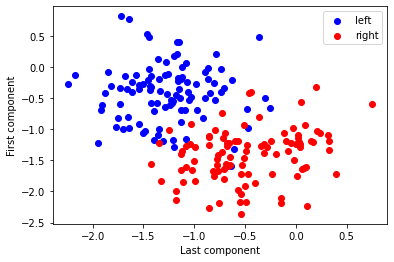

In [27]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

We will apply a linear classifier to this data. A linear classifier can be thought of as drawing a line in the above plot to separate the two classes. To determine the class for a new trial, we just check on which side of the line the trial would be if plotted as above.

The data is split into a train and a test set. The classifier will fit a model (in this case, a straight line) on the training set and use this model to make predictions about the test set (see on which side of the line each trial in the test set falls). Note that the CSP algorithm is part of the model, so for fairness sake it should be calculated using only the training data.

In [61]:
# Percentage of trials to use for training (50-50 split here)
train_percentage = 0.5 

# Calculate the number of trials for each class the above percentage boils down to
ntrain_r = int(trials_filt[cl1].shape[2] * train_percentage)
ntrain_f = int(trials_filt[cl2].shape[2] * train_percentage)
ntest_r = trials_filt[cl1].shape[2] - ntrain_r
ntest_f = trials_filt[cl2].shape[2] - ntrain_f

# Splitting the frequency filtered signal into a train and test set
train = {cl1: trials_filt[cl1][:,:,:ntrain_r],
         cl2: trials_filt[cl2][:,:,:ntrain_f]}

test = {cl1: trials_filt[cl1][:,:,ntrain_r:],
        cl2: trials_filt[cl2][:,:,ntrain_f:]}

# Train the CSP on the training set only
W = csp(train[cl1], train[cl2])

# Apply the CSP on both the training and test set
train[cl1] = apply_mix(W, train[cl1])
train[cl2] = apply_mix(W, train[cl2])
test[cl1] = apply_mix(W, test[cl1])
test[cl2] = apply_mix(W, test[cl2])

In [63]:
# Select only the first and last components for classification
comp = np.array([0,-1])
train[cl1] = train[cl1][comp,:,:]
train[cl2] = train[cl2][comp,:,:]
test[cl1] = test[cl1][comp,:,:]
test[cl2] = test[cl2][comp,:,:]


In [65]:
# Calculate the log-var
train[cl1] = logvar(train[cl1])
train[cl2] = logvar(train[cl2])
test[cl1] = logvar(test[cl1])
test[cl2] = logvar(test[cl2])

In [66]:
train[cl1].shape

(2, 50)

For a classifier the Linear Discriminant Analysis (LDA) algorithm will be used. It fits a gaussian distribution to each class, characterized by the mean and covariance, and determines an optimal separating plane to divide the two. This plane is defined as $r = W_0 \cdot X_0 + W_1 \cdot X_1 + \ldots + W_n \cdot X_n - b$, where $r$ is the classifier output, $W$ are called the feature weights, $X$ are the features of the trial, $n$ is the dimensionality of the data and $b$ is called the offset.

In our case we have 2 dimensional data, so the separating plane will be a line: $r = W_0 \cdot X_0 + W_1 \cdot X_1 - b$. To determine a class label for an unseen trial, we can calculate whether the result is positive or negative.

In [29]:
def train_lda(class1, class2):
    '''
    Trains the LDA algorithm.
    arguments:
        class1 - An array (observations x features) for class 1
        class2 - An array (observations x features) for class 2
    returns:
        The projection matrix W
        The offset b
    '''
    nclasses = 2
    
    nclass1 = class1.shape[0]
    nclass2 = class2.shape[0]
    
    # Class priors: in this case, we have an equal number of training
    # examples for each class, so both priors are 0.5
    prior1 = nclass1 / float(nclass1 + nclass2)
    prior2 = nclass2 / float(nclass1 + nclass1)
   
    mean1 = np.mean(class1, axis=0)
    mean2 = np.mean(class2, axis=0)
    
    class1_centered = class1 - mean1
    class2_centered = class2 - mean2
    
    # Calculate the covariance between the features
    cov1 = class1_centered.T.dot(class1_centered) / (nclass1 - nclasses)
    cov2 = class2_centered.T.dot(class2_centered) / (nclass2 - nclasses)
   
    W = (mean2 - mean1).dot(np.linalg.pinv(prior1*cov1 + prior2*cov2))
    b = (prior1*mean1 + prior2*mean2).dot(W)
    
    return (W,b)

def apply_lda(test, W, b):
    '''
    Applies a previously trained LDA to new data.
    arguments:
        test - An array (features x trials) containing the data
        W    - The project matrix W as calculated by train_lda()
        b    - The offsets b as calculated by train_lda()
    returns:
        A list containing a classlabel for each trial
    '''
    ntrials = test.shape[1]
    
    prediction = []
    for i in range(ntrials):
        # The line below is a generalization for:
        # result = W[0] * test[0,i] + W[1] * test[1,i] - b
        result = W.dot(test[:,i]) - b
        if result <= 0:
            prediction.append(1)
        else:
            prediction.append(2)
    
    return np.array(prediction)

In [32]:
train[cl1].shape

(2, 50)

Training the LDA using the training data gives us $W$ and $b$:

In [67]:
W,b = train_lda(train[cl1].T, train[cl2].T)

print('W:', W)
print('b:', b)

W: [ 5.31347949 -5.52963938]
b: 0.3802472103807988


It can be informative to recreate the scatter plot and overlay the decision boundary as determined by the LDA classifier. The decision boundary is the line for which the classifier output is exactly 0. The scatterplot used $X_0$ as $x$-axis and $X_1$ as $y$-axis. To find the function $y = f(x)$ describing the decision boundary, we set $r$ to 0 and solve for $y$ in the equation of the separating plane:

<div style="width:600px">
$$\begin{align}
W_0 \cdot X_0 + W_1 \cdot X_1 - b &= r &&\text{the original equation} \\\
W_0 \cdot x + W_1 \cdot y - b &= 0     &&\text{filling in $X_0=x$, $X_1=y$ and $r=0$} \\\
W_0 \cdot x + W_1 \cdot y &= b         &&\text{solving for $y$}\\\
W_1 \cdot y &= b - W_0 \cdot x \\\
\\\
y &= \frac{b - W_0 \cdot x}{W_1}
\end{align}$$
</div>

We first plot the decision boundary with the training data used to calculate it:

(-2.2, 1.0)

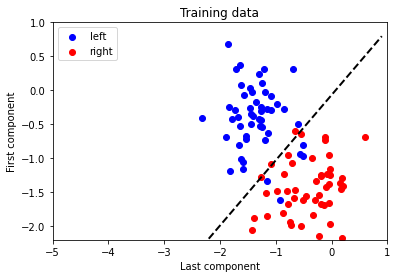

In [31]:
# Scatterplot like before
plot_scatter(train[cl1], train[cl2])
title('Training data')

# Calculate decision boundary (x,y)
x = np.arange(-5, 1, 0.1)
y = (b - W[0]*x) / W[1]

# Plot the decision boundary
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

The code below plots the boundary with the test data on which we will apply the classifier. You will see the classifier is going to make some mistakes.

(-2.2, 1.0)

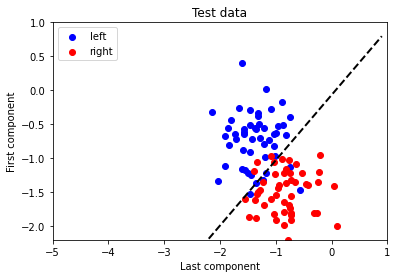

In [68]:
plot_scatter(test[cl1], test[cl2])
title('Test data')
plt.plot(x,y, linestyle='--', linewidth=2, color='k')
plt.xlim(-5, 1)
plt.ylim(-2.2, 1)

Now the LDA is constructed and fitted to the training data. We can now apply it to the test data. The results are presented as a confusion matrix:
    
<table>
    <tr><td></td><td colspan='2' style="font-weight:bold">True labels →</td></tr>
    <tr><td style="font-weight:bold">↓ Predicted labels</td><td>Right</td><td>Foot</td></tr>
    <tr><td>Right</td><td></td><td></td></tr>
    <tr><td>Foot</td><td></td><td></td></tr>
</table>

The number at the diagonal will be trials that were correctly classified, any trials incorrectly classified (either a false positive or false negative) will be in the corners.

In [69]:
# Print confusion matrix
conf = np.array([
    [(apply_lda(test[cl1], W, b) == 1).sum(), (apply_lda(test[cl2], W, b) == 1).sum()],
    [(apply_lda(test[cl1], W, b) == 2).sum(), (apply_lda(test[cl2], W, b) == 2).sum()],
])

print('Confusion matrix:')
print(conf)
print()
print('Accuracy: %.3f' % (np.sum(np.diag(conf)) / float(np.sum(conf))))

Confusion matrix:
[[45  4]
 [ 5 46]]

Accuracy: 0.910


The confusion matrix shows that 4 out of the 50 trials with foot movement were incorrectly classified as right hand movement and 5 out of the 50 trials with right hand movement were incorrectly classified as foot movement. In total, 91% of the trials were correctly classified, not a bad score!

If you want, you can continue with the next tutorial:
[4. Classifiying the P300](4.%20Classifying%20the%20P300.ipynb)